In [1]:
import json
import os
import warnings


def create_dir(path):
    dir_path = os.path.dirname(path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"{dir_path} : has been created successfully")
    else:
        print(f"{dir_path} : has already exist")


def jload(path, lines=True):
    if not os.path.exists(path):
        raise ValueError("path not exist")
    if lines is True:
        data = [json.loads(_) for _ in open(path, "r", encoding="utf-8") if _ != ""]
    else:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    return data


def jdump(obj, path, mode="w", lines=True, indent=4):
    assert type(obj) is list or type(obj) is dict
    if mode != "w" and mode != "a":
        raise ValueError("error mode")
    if not os.path.exists(os.path.dirname(path)):
        create_dir(path)
    if type(obj) is dict:
        obj = [obj]

    if lines is True:
        with open(path, mode, encoding="utf-8") as f:
            for item in obj:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")
    else:
        if mode == "w":
            with open(path, "w") as f:
                json.dump(obj, f, indent=indent, ensure_ascii=False)
        elif mode == "a":
            with open(path, "a+") as f:
                data = json.load(path)
                json.dump(data + obj, f, indent=indent, ensure_ascii=False)


def read_file(path):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    return text


In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns



def get_annotations(data_dir, index=0):
    path= Path(data_dir)
    outs={}
    for i,p in enumerate(path.glob("*.json")):
        if i!=index:
            continue
        data=jload(p,lines=False)
        out=[]
        for item in data:
            labels=[]
            ann=item['annotations'][0]
            results=ann['result']
            for r in results:
                v=r['value']
                labels.append([v['start'],v['end'],v['labels'][0]])
            item=item['data']
            item['label']=labels
            out.append(item)
        outs[str(p)]=out
    return outs


def style_check(row):
    label=row['label']
    for l in label:
        if l[2] in ["Unnatural Phrase Flow","Unnatural Sentence Flow"]:
            return True
    return False


def style_ratio_check(row):
    tranlation_len=len(row['translation'])
    style_err_length=0
    label=row['label']
    for l in label:
        if l[2] in  ["Unnatural Phrase Flow","Unnatural Sentence Flow"]:
            style_err_length+=l[1]-l[0]
    return style_err_length/tranlation_len

In [3]:

from collections import defaultdict

datass=defaultdict(list)

for j in range(3):
    for i in range(10):        
        delta = get_annotations(f"./enzh/task{i}", index=j)
        for k,v in delta.items():
            datass[j] += v

# Create a list to hold all the data
all_data = []

# Iterate through the datass dictionary
for annotator, annotations in datass.items():
    for annotation in annotations:
        # Add the annotator information to each annotation
        annotation['annotator'] = f'Annotator_{annotator}'
        all_data.append(annotation)

# Create a DataFrame from the list of all data
df = pd.DataFrame(all_data)

# Compute style_err_ratio for each annotation
df["style_err_ratio"] = df.apply(style_ratio_check, axis=1)

# Add an instance_id column (assuming each annotator annotated the same instances in the same order)
df['instance_id'] = df.groupby('annotator').cumcount()

# Group by instance_id and calculate the mean style_err_ratio across annotators
avg_stats = df.groupby('instance_id').agg({
    'style_err_ratio': 'mean',
    'type': 'first'  # Assuming 'type' is the same for all annotators for a given instance
}).reset_index()

# Rename the column for clarity
avg_stats = avg_stats.rename(columns={'style_err_ratio': 'avg_style_err_ratio'})

# Display the first few rows of the averaged statistics
print(avg_stats.head())

# Display information about the averaged statistics DataFrame
print(avg_stats.info())

# Calculate overall average for each type
type_averages = avg_stats.groupby('type')['avg_style_err_ratio'].mean().sort_values(ascending=False)

print("\nOverall averages by type:")
print(type_averages)

avg_stats

   instance_id  avg_style_err_ratio                     type
0            0             0.155673      gpt-3.5-turbo_trans
1            1             0.238468    gpt-4-turbo_ctx_pivot
2            2             0.204663      gpt-4-turbo_end2end
3            3             0.154047        gpt-4-turbo_trans
4            4             0.125754  gpt-3.5-turbo_ctx_pivot
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   instance_id          1800 non-null   int64  
 1   avg_style_err_ratio  1800 non-null   float64
 2   type                 1800 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 42.3+ KB
None

Overall averages by type:
type
mistral_trans              0.322726
gpt-3.5-turbo_end2end      0.226120
gpt-3.5-turbo_trans        0.220042
gpt-4-turbo_trans          0.197264
gpt-3.5-turbo_ctx_pivot    0.19596

,instance_id,avg_style_err_ratio,type
0,0,0.155673,gpt-3.5-turbo_trans
1,1,0.238468,gpt-4-turbo_ctx_pivot
2,2,0.204663,gpt-4-turbo_end2end
3,3,0.154047,gpt-4-turbo_trans
4,4,0.125754,gpt-3.5-turbo_ctx_pivot
...,...,...,...
1795,1795,0.260908,gpt-4-turbo_trans
1796,1796,0.046961,alma_7B_trans
1797,1797,0.043290,gpt-3.5-turbo_end2end
1798,1798,0.174242,alma_13B_trans


/var/folders/54/3z7sp72j3pv26qrp65kwtbvc0000gn/T/ipykernel_44751/2180045635.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bar_severe.index, y=bar_severe.values, palette=colors, edgecolor='black')
/var/folders/54/3z7sp72j3pv26qrp65kwtbvc0000gn/T/ipykernel_44751/2180045635.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ALMA-7B','ALMA-13B','Mistral-7B','GPT-3.5','GPT-3.5-Specified','GPT-3.5-Polish', 'GPT-4', 'GPT-4-Specified','GPT-4-Polish',])


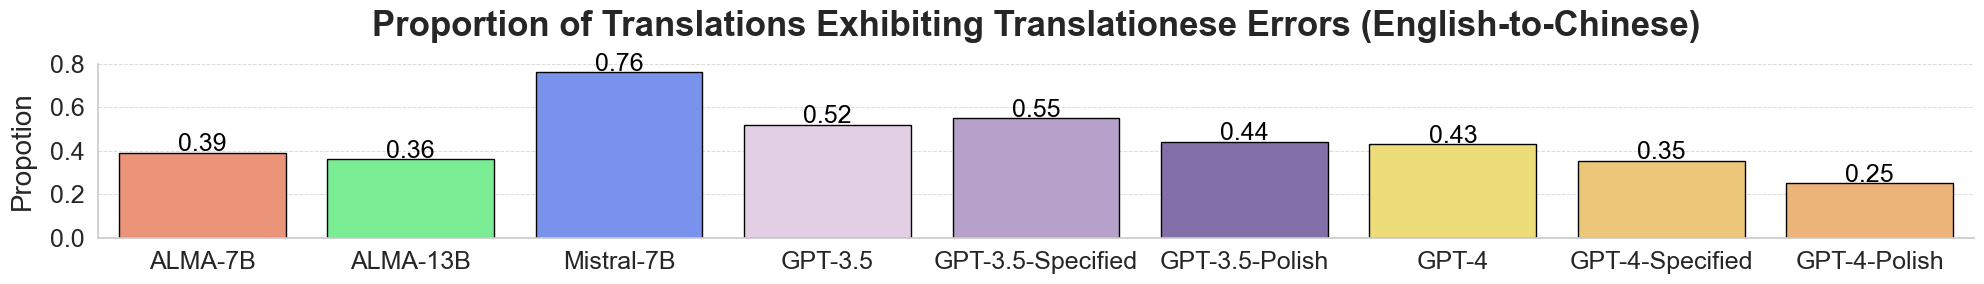

In [4]:
avg_stats["err"]=avg_stats['avg_style_err_ratio']>0.2

bar_severe=avg_stats[['type','err']].groupby("type").mean()['err']
desired_order = ['alma_7B_trans',
                  'alma_13B_trans', 
                  'mistral_trans', 
                 'gpt-3.5-turbo_trans',
                  'gpt-3.5-turbo_end2end',  
                 'gpt-3.5-turbo_ctx_pivot',
                 'gpt-4-turbo_trans',
                 'gpt-4-turbo_end2end', 
                 'gpt-4-turbo_ctx_pivot', ]
bar_severe = bar_severe.reindex(desired_order)

# Set the overall aesthetic style
sns.set_theme(style="whitegrid")

# Sample data (replace 'bar' with your actual data)
# bar.index = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9']
# bar.values = [0.75, 0.80, 0.78, 0.82, 0.85, 0.79, 0.81, 0.76, 0.83]  # Replace with your actual data

# Define the color palette
colors = ['#FF8A66', '#66FF8A', '#6688FF',  # Softer versions of original isolated colors
          '#E6CCE6', '#B59BCF', '#8066B3',  # Muted purple shades
          '#FFEB66', '#FFCC66', '#FFB566']  # Muted orange shades

plt.figure(figsize=(20, 3))  # Adjust figure size for better readability

# Create the bar plot
ax = sns.barplot(x=bar_severe.index, y=bar_severe.values, palette=colors, edgecolor='black')
ax.set_xticklabels(['ALMA-7B','ALMA-13B','Mistral-7B','GPT-3.5','GPT-3.5-Specified','GPT-3.5-Polish', 'GPT-4', 'GPT-4-Specified','GPT-4-Polish',])
# Add titles and labels with bold fonts for emphasis
# plt.xlabel("Model", fontsize=25, labelpad=10, fontweight='bold')
plt.xlabel('') 
plt.ylabel("Propotion", fontsize=20, labelpad=10)
plt.title("Proportion of Translations Exhibiting Translationese Errors (English-to-Chinese)", fontsize=25, fontweight='bold', pad=20)
# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=18)
plt.yticks(fontsize=18)
# Add value labels on top of the bars
for i, value in enumerate(bar_severe.values):
    ax.text(i, value + bar_severe.max() * 0.01, f'{value:.2f}', ha='center', fontsize=18, color='black')

# Remove the top and right spines for a cleaner look
sns.despine()

# Add a subtle grid to the background
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.ylim(0,0.8)
# Improve layout for better appearance
plt.tight_layout()

# Show the plot
plt.savefig("./enzh.tsr.pdf")
plt.show()